# Table of Contents 

* [Imports & Functions](#imports-and-functions)
* [Trend, Seasonality & Stationarity](#trend-seasonality-stationarity)
* [Baseline Models](#baseline-models)
    * [Simple Moving Average](#SMA)
    * [SARIMA](#SARIMA)
    * [Holt-Winters](#Holt-Winters)

# Imports & Functions <a class="anchor" id="imports-and-functions"></a>

In [61]:
#Basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


#Stats 
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


#File-handling
import json
import csv


#Training and Evaluation 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [62]:
#Stats
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
        
#Models
def sma_forecast(train, test, window):
    forecast = []
    temp_train = train.copy()  # Create a copy to avoid modifying the original train data
    for i in range(len(test)):
        mean_value = temp_train.iloc[-window:].mean()  # Calculate the mean of the last `window` values
        forecast.append(mean_value)
        temp_train = pd.concat([temp_train, pd.Series([test.iloc[i]], index=[test.index[i]])])
    return pd.Series(forecast, index=test.index)
        
#Evaluation
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def custom_mape(actual, forecast, epsilon=1e-10):
    """
    Custom MAPE calculation that handles zero and near-zero values.
    
    Parameters:
    - actual: array-like, actual values
    - forecast: array-like, forecasted values
    - epsilon: small constant to replace zero values
    
    Returns:
    - mape: Mean Absolute Percentage Error
    """
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Replace zero values in actual with epsilon to avoid division by zero
    actual = np.where(actual == 0, epsilon, actual)
    
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [63]:
#Reading in training data 
X_train_front = pd.read_csv('X_train_front_log_transformed.csv')
y_train_front = pd.read_csv('y_train_front_log_transformed.csv')
X_train_second = pd.read_csv('X_train_second_log_transformed.csv')
y_train_second = pd.read_csv('y_train_second_log_transformed.csv')

In [64]:
#Reading in test data 
X_test_front = pd.read_csv('X_test_front_log_transformed.csv')
y_test_front = pd.read_csv('y_test_front_log_transformed.csv')
X_test_second = pd.read_csv('X_test_second_log_transformed.csv')
y_test_second = pd.read_csv('y_test_second_log_transformed.csv')

In [65]:
#Setting indices of X and y datasets 

X_train_front.set_index('Date', inplace=True)
X_train_second.set_index('Date', inplace=True)

X_test_front.set_index('Date', inplace=True)
X_test_second.set_index('Date',inplace=True)

y_train_front.set_index('Date', inplace=True)
y_train_second.set_index('Date', inplace=True)

y_test_front.set_index('Date', inplace=True)
y_test_second.set_index('Date',inplace=True)

# Trend, Seasonality & Stationarity  <a class="anchor" id="trend-seasonality-stationarity"></a>

<Axes: xlabel='Date'>

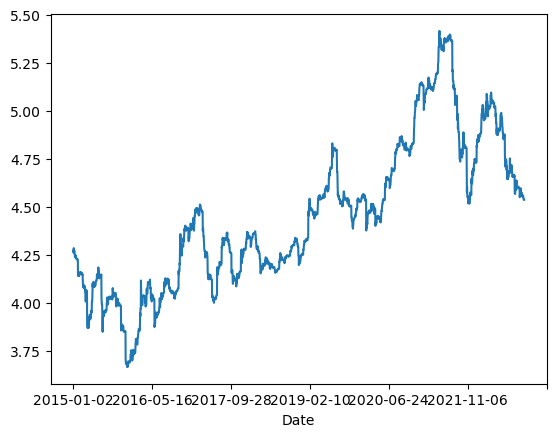

In [66]:
y_train_front['CLOSE_x'].plot()

<Axes: xlabel='Date'>

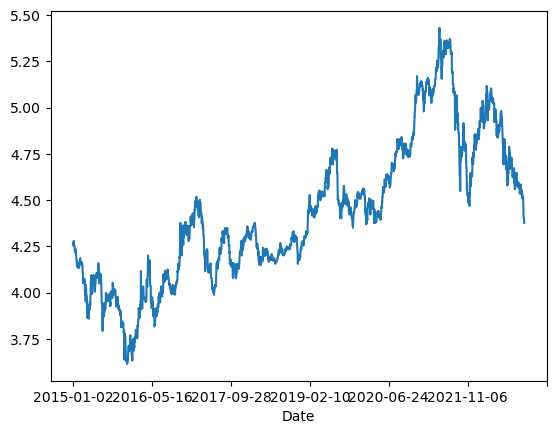

In [67]:
y_train_second['CLOSE_y'].plot()

We maintain the general upward trend of our target variable close price over time for both front-month and second-month contracts

## Seasonal Decomposition

### Weekly Seasonality

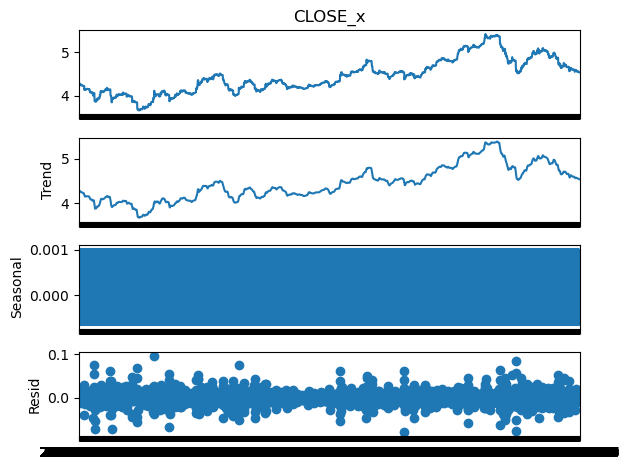

In [68]:
#Seasonal decomposition of close price for front-month contracts 

period = 7 #assuming weekly seasonality
decomposition_1_front = seasonal_decompose(y_train_front['CLOSE_x'], model='additive', period=period)
decomposition_1_front.plot()
plt.show()

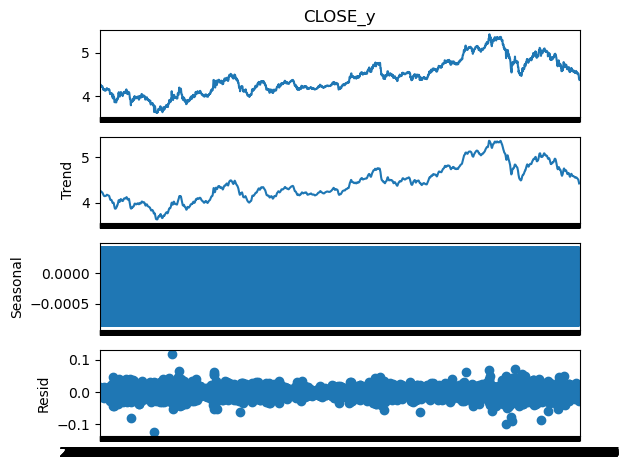

In [69]:
#Seasonal decomposition of close price for second-month contracts 

period = 7 #assuming weekly seasonality
decomposition_1_second = seasonal_decompose(y_train_second['CLOSE_y'], model='additive', period=period)
decomposition_1_second.plot()
plt.show()

### Bi-Weekly Seasonality 

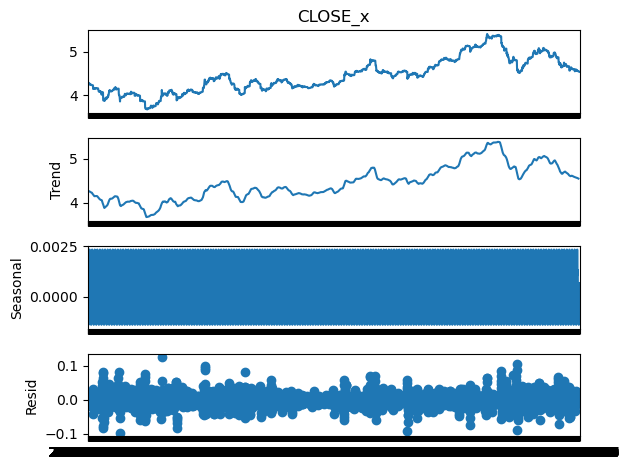

In [70]:
#Seasonal decomposition of close price for front-month contracts 

period = 15 #assuming bi-weekly seasonality
decomposition_2_front = seasonal_decompose(y_train_front['CLOSE_x'], model='additive', period=period)
decomposition_2_front.plot()
plt.show()

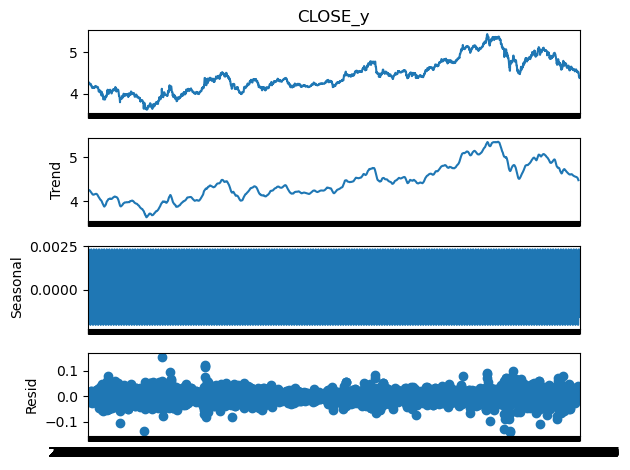

In [71]:
#Seasonal decomposition of close price for second-month contracts 

period = 15 #assuming bi-weekly seasonality
decomposition_2_second = seasonal_decompose(y_train_second['CLOSE_y'], model='additive', period=period)
decomposition_2_second.plot()
plt.show()

### Monthly seasonality

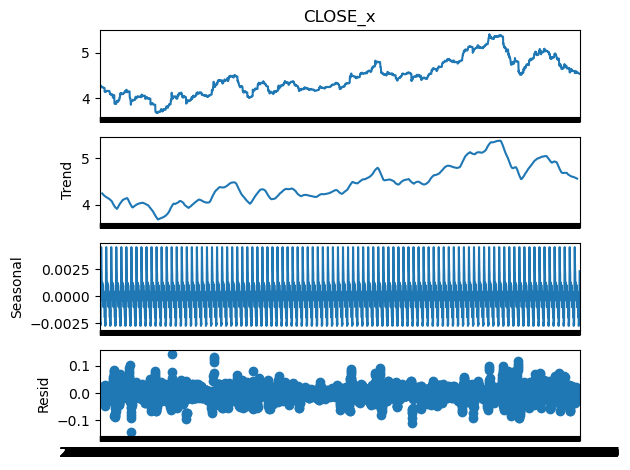

In [72]:
#Seasonal decomposition of close price for front-month contracts 

period = 30 #assuming monthly seasonality
decomposition_3_front = seasonal_decompose(y_train_front['CLOSE_x'], model='additive', period=period)
decomposition_3_front.plot()
plt.show()

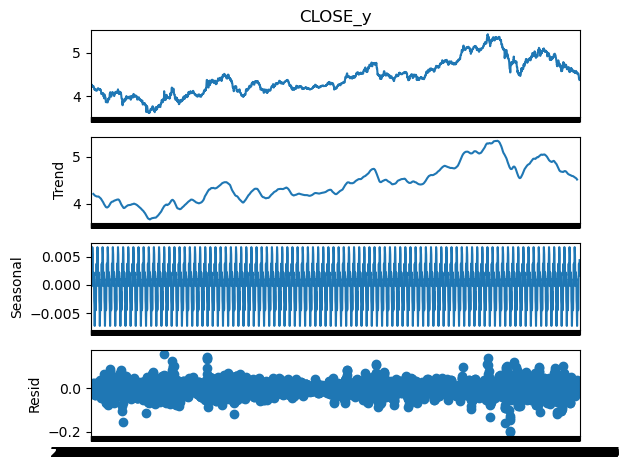

In [73]:
#Seasonal decomposition of close price for second-month contracts 

period = 30 #assuming monthly seasonality
decomposition_3_second = seasonal_decompose(y_train_second['CLOSE_y'], model='additive', period=period)
decomposition_3_second.plot()
plt.show()

## Autocorrelation

### Weekly Autocorrelation

<Figure size 1000x500 with 0 Axes>

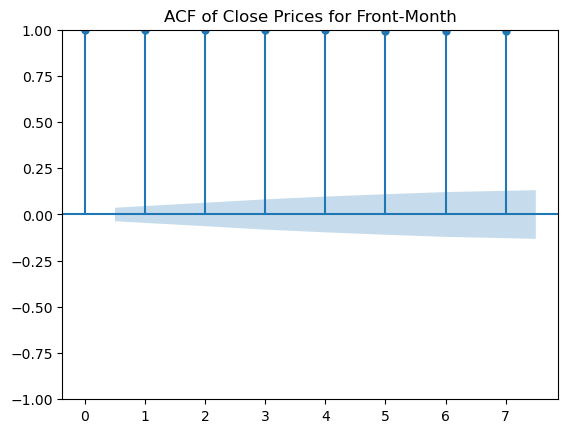

In [74]:
#Plotting ACF to check autocorrelation within Close prices of front-month contracts 

plt.figure(figsize=(10, 5))
plot_acf(y_train_front['CLOSE_x'], lags=7) 
plt.title('ACF of Close Prices for Front-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

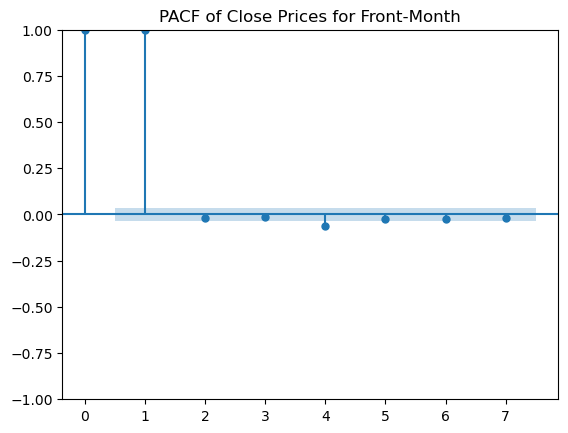

In [75]:
#Plotting PACF 

plt.figure(figsize=(10, 5))
plot_pacf(y_train_front['CLOSE_x'], lags=7) 
plt.title('PACF of Close Prices for Front-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

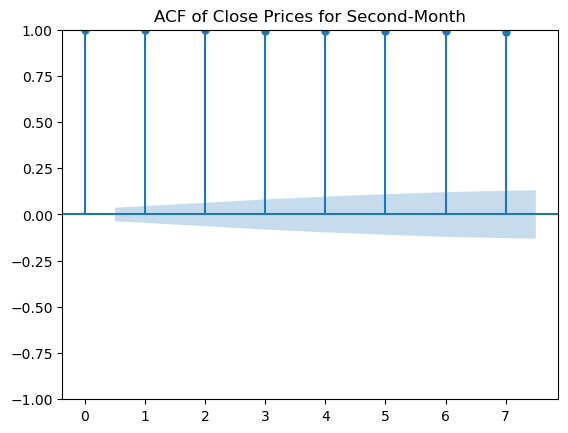

In [76]:
#Plotting ACF to check autocorrelation within Close prices of second-month contracts 

plt.figure(figsize=(10, 5))
plot_acf(y_train_second['CLOSE_y'], lags=7)
plt.title('ACF of Close Prices for Second-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

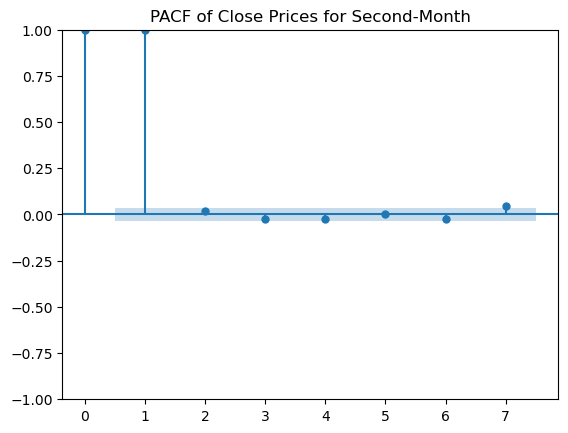

In [77]:
#Plotting PACF 

plt.figure(figsize=(10, 5))
plot_pacf(y_train_second['CLOSE_y'], lags=7) 
plt.title('PACF of Close Prices for Second-Month')
plt.show()

### Bi-Weekly Autocorrelation

<Figure size 1000x500 with 0 Axes>

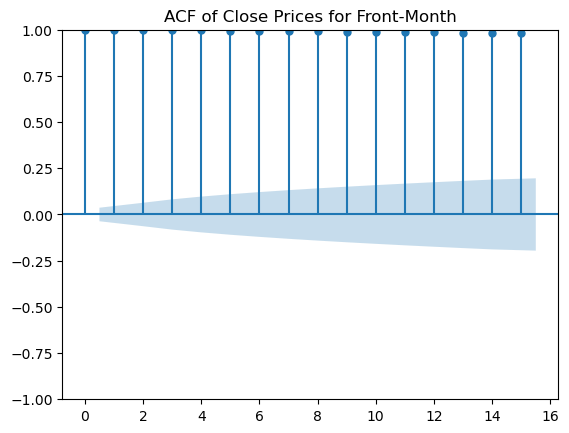

In [78]:
#Plotting ACF to check autocorrelation within Close prices of front-month contracts 

plt.figure(figsize=(10, 5))
plot_acf(y_train_front['CLOSE_x'], lags=15) 
plt.title('ACF of Close Prices for Front-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

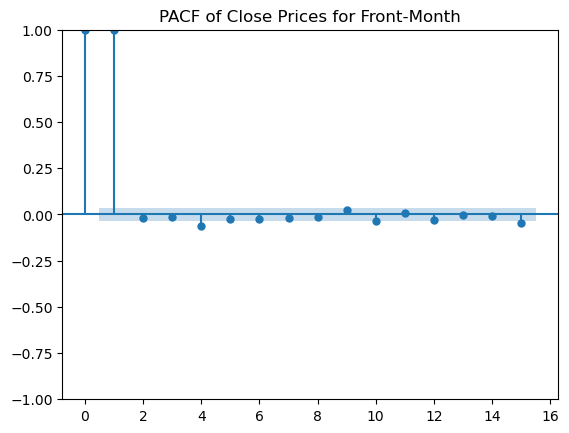

In [79]:
#Plotting PACF  

plt.figure(figsize=(10, 5))
plot_pacf(y_train_front['CLOSE_x'], lags=15) 
plt.title('PACF of Close Prices for Front-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

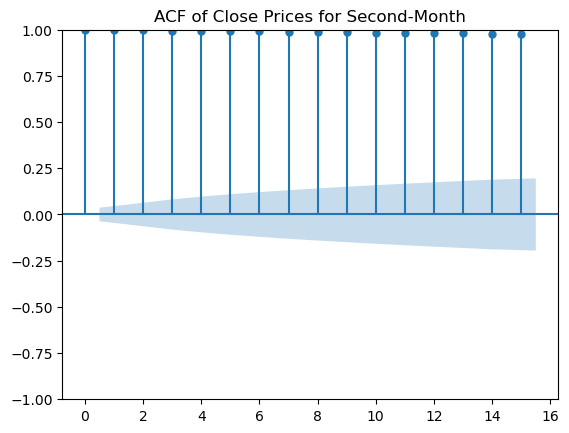

In [80]:
#Plotting ACF to check autocorrelation within Close prices of second-month contracts 

plt.figure(figsize=(10, 5))
plot_acf(y_train_second['CLOSE_y'], lags=15) 
plt.title('ACF of Close Prices for Second-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

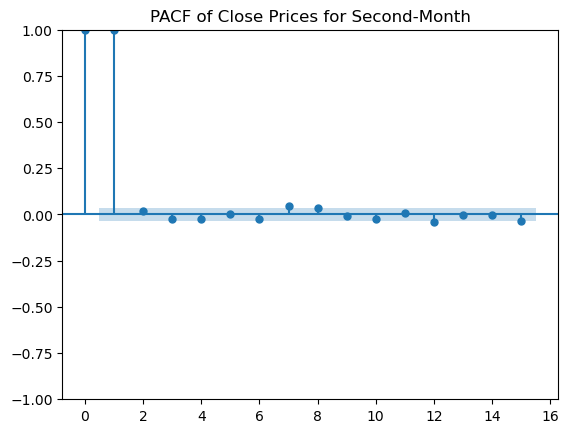

In [81]:
#Plotting PACF 

plt.figure(figsize=(10, 5))
plot_pacf(y_train_second['CLOSE_y'], lags=15) 
plt.title('PACF of Close Prices for Second-Month')
plt.show()

### Monthly autocorrelation

<Figure size 1000x500 with 0 Axes>

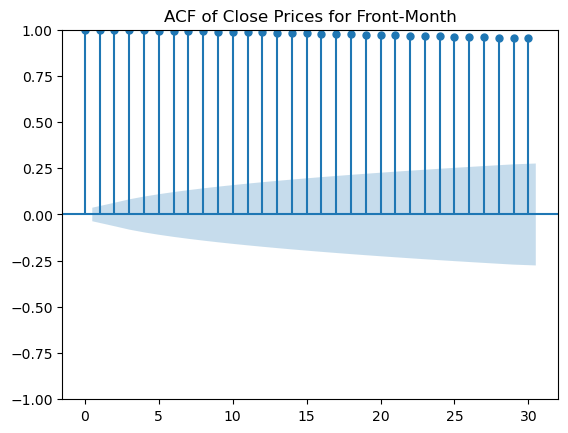

In [82]:
#Plotting ACF to check autocorrelation within Close prices of front-month contracts 

plt.figure(figsize=(10, 5))
plot_acf(y_train_front['CLOSE_x'], lags=30) 
plt.title('ACF of Close Prices for Front-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

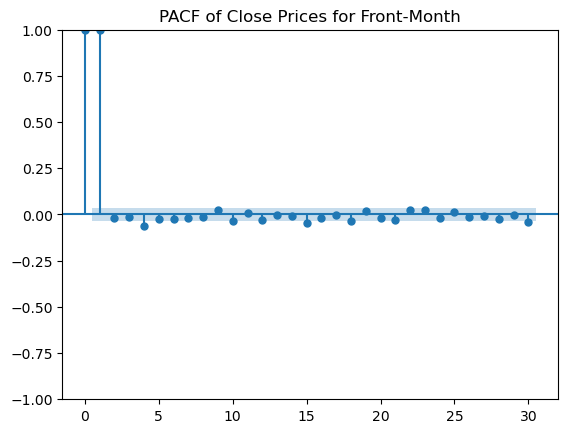

In [83]:
#Plotting PACF

plt.figure(figsize=(10, 5))
plot_pacf(y_train_front['CLOSE_x'], lags=30) 
plt.title('PACF of Close Prices for Front-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

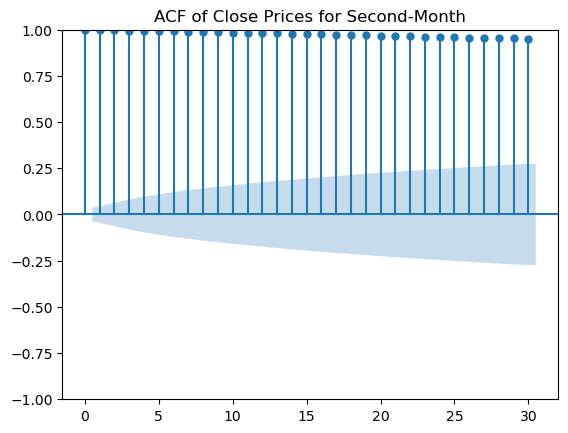

In [84]:
#Plotting ACF to check autocorrelation within Close prices of second-month contracts 

plt.figure(figsize=(10, 5))
plot_acf(y_train_second['CLOSE_y'], lags=30) 
plt.title('ACF of Close Prices for Second-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

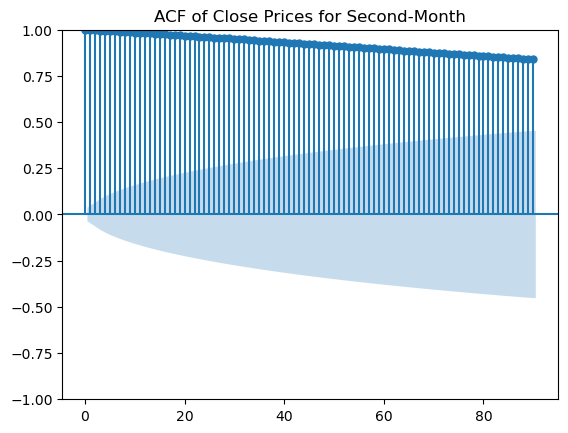

In [85]:
#Plotting ACF to check autocorrelation within Close prices of second-month contracts 

plt.figure(figsize=(10, 5))
plot_acf(y_train_second['CLOSE_y'], lags=90) 
plt.title('ACF of Close Prices for Second-Month')
plt.show()

<Figure size 1000x500 with 0 Axes>

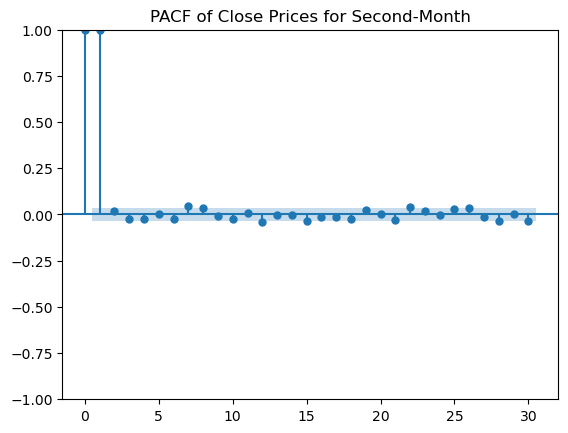

In [86]:
#Plotting PACF 

plt.figure(figsize=(10, 5))
plot_pacf(y_train_second['CLOSE_y'], lags=30)
plt.title('PACF of Close Prices for Second-Month')
plt.show()

The plots above suggest there a general upward trend over time with the likelihood of monthly seasonality. 

The ACF plot reveals a positive correlation between the current value and the previous lags within the current month but a sharp decline in PACF plot after the first lag suggests that the direction autocorrelation is limited to the previous value. 

We conclude that our target variable close price exhibits seasonality and significant autocorrelation with lagged values. This will inform our choice of baseline model and training parameters. 

## Stationarity Check 

Time-series data often has non-stationary or variance in statistical properties at different temporal divisions within the period of investigation. Some models require the data to be stationary and so we will perform this check using an Augmented Dickey-Fuller Test. 

In [87]:
#Applying ADF test on y datasets for front-month

adf_result_y_train_front = adf_test(y_train_front)
adf_result_y_train_front

ADF Statistic: -1.313223293048524
p-value: 0.623101137059699
Critical Values:
   1%, -3.432642535640906
Critical Values:
   5%, -2.8625528854376623
Critical Values:
   10%, -2.567309188752335


In [88]:
#Applying ADF test on y datasets for second-month
adf_result_y_train_second = adf_test(y_train_second)
adf_result_y_train_second

ADF Statistic: -1.4512227901781893
p-value: 0.5574881308329841
Critical Values:
   1%, -3.43264575500919
Critical Values:
   5%, -2.862554307267278
Critical Values:
   10%, -2.567309945727228


In both cases, we observe a p-value greater than 5% and so we reject the null hypothesis that the series is stationary. Hence, it is confirmed that our training time series are non-stationary. 

## Differencing Time Series

In [90]:
#First-order differencing
y_train_front_diff = y_train_front.diff().dropna()
adf_test(y_train_front_diff)

ADF Statistic: -28.400644618134088
p-value: 0.0
Critical Values:
   1%, -3.432642535640906
Critical Values:
   5%, -2.8625528854376623
Critical Values:
   10%, -2.567309188752335


In [91]:
#Seasonal-differencing

y_train_front_seasonal_diff1 = y_train_front.diff(30).dropna()
adf_test(y_train_front_seasonal_diff1)

ADF Statistic: -8.025907731107463
p-value: 2.0177423556809423e-12
Critical Values:
   1%, -3.432680943017927
Critical Values:
   5%, -2.862569847903434
Critical Values:
   10%, -2.5673182195000446


In [92]:
y_train_second_diff = y_train_second.diff().dropna()
adf_test(y_train_second_diff)

ADF Statistic: -21.082899749289396
p-value: 0.0
Critical Values:
   1%, -3.43264575500919
Critical Values:
   5%, -2.862554307267278
Critical Values:
   10%, -2.567309945727228


In [93]:
y_train_second_seasonal_diff1 = y_train_second.diff(30).dropna()
adf_test(y_train_second_seasonal_diff1)

ADF Statistic: -8.653524672535527
p-value: 5.040232265308517e-14
Critical Values:
   1%, -3.4326867736466333
Critical Values:
   5%, -2.862572422958406
Critical Values:
   10%, -2.5673195904520254


We observe that one level of differencing and one level of seasonal differencing is sufficient to convert the data to stationary

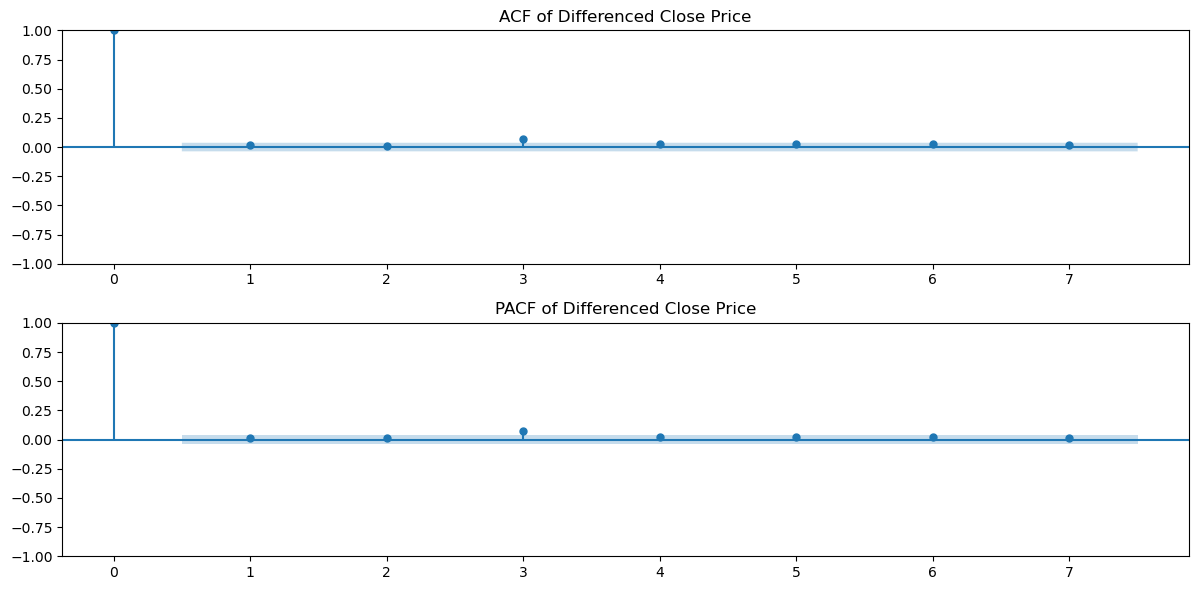

In [94]:
#Plotting ACF and PACF for non-seasonal and seasonal identification
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(y_train_front_diff, lags=7, ax=plt.gca())
plt.title('ACF of Differenced Close Price')

plt.subplot(212)
plot_pacf(y_train_front_diff, lags=7, ax=plt.gca())
plt.title('PACF of Differenced Close Price')

plt.tight_layout()
plt.show()

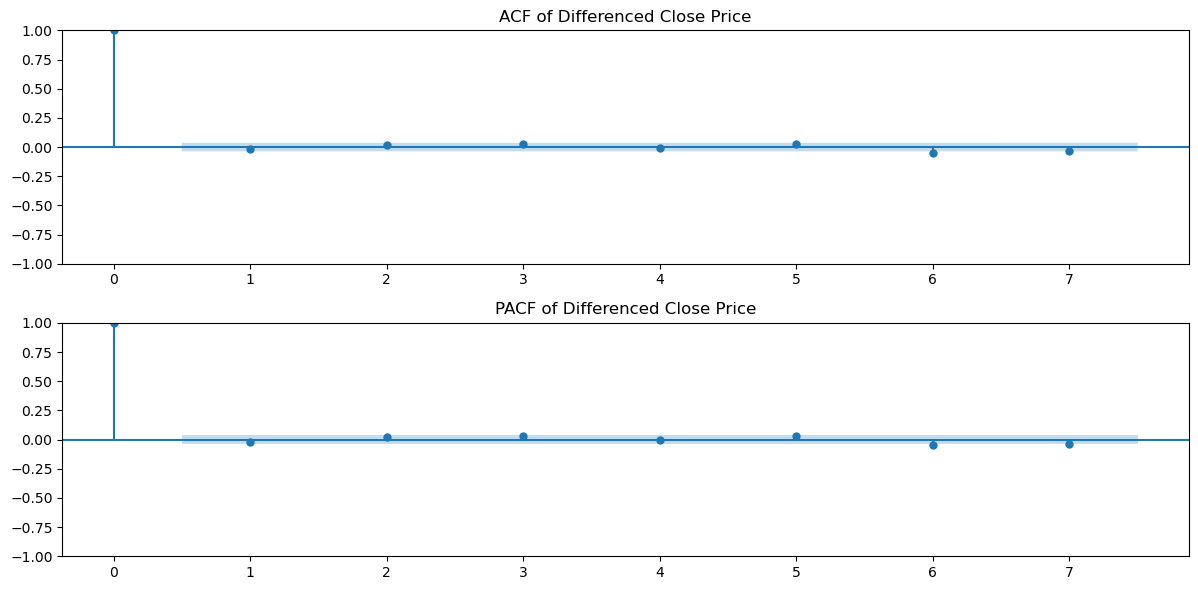

In [95]:
#Plotting ACF and PACF for non-seasonal and seasonal identification
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(y_train_second_diff, lags=7, ax=plt.gca())
plt.title('ACF of Differenced Close Price')

plt.subplot(212)
plot_pacf(y_train_second_diff, lags=7, ax=plt.gca())
plt.title('PACF of Differenced Close Price')

plt.tight_layout()
plt.show()

The ACF and PACF plots of the differenced series reveal statistically-significant values up to first-order lag 

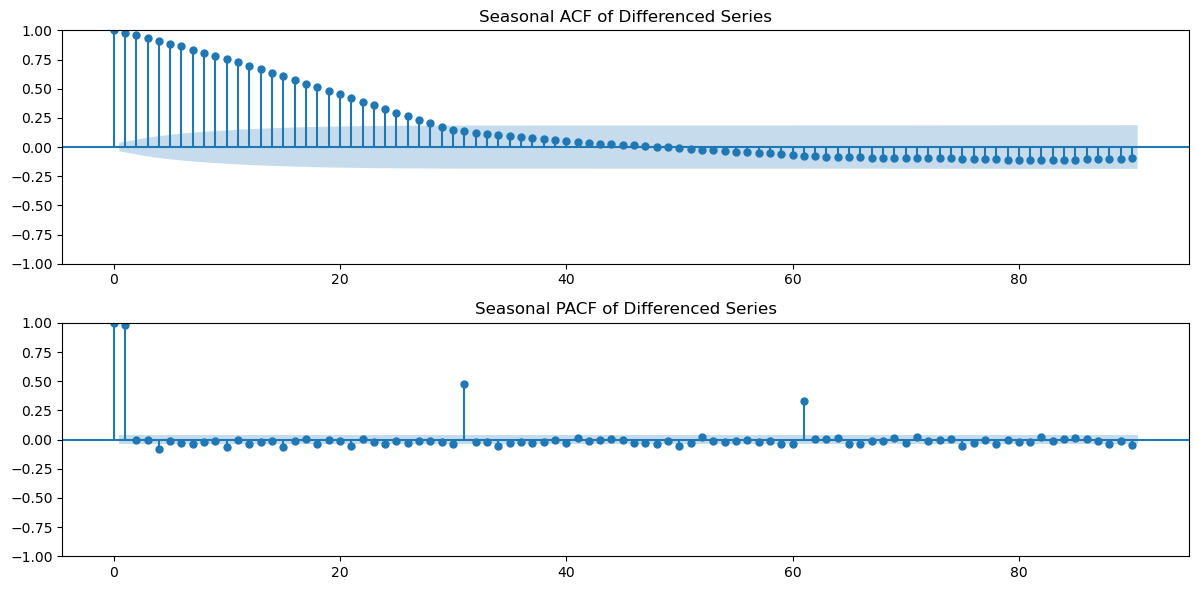

In [96]:
# Plot ACF and PACF for non-seasonal and seasonal identification
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(y_train_front_seasonal_diff1, lags=90, ax=plt.gca())
plt.title('Seasonal ACF of Differenced Series')

plt.subplot(212)
plot_pacf(y_train_front_seasonal_diff1, lags=90, ax=plt.gca())
plt.title('Seasonal PACF of Differenced Series')

plt.tight_layout()
plt.show()

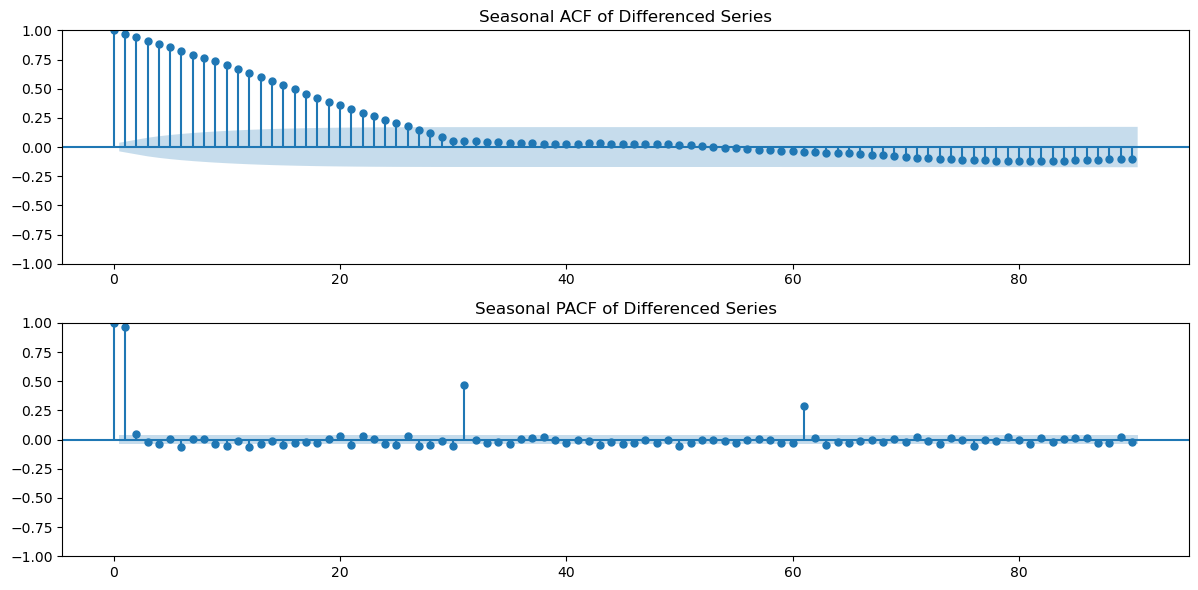

In [97]:
#Plotting ACF and PACF for non-seasonal and seasonal identification
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(y_train_second_seasonal_diff1, lags=90, ax=plt.gca())
plt.title('Seasonal ACF of Differenced Series')

plt.subplot(212)
plot_pacf(y_train_second_seasonal_diff1, lags=90, ax=plt.gca())
plt.title('Seasonal PACF of Differenced Series')

plt.tight_layout()
plt.show()

The ACF and PACF of the seasonally-differenced series reveal statistically-significant values up to 1 seasonal lag 

# Baseline Models <a class="anchor" id="baseline-models"></a>

## Simple Moving Average <a class="anchor" id="SMA"></a>

In [98]:
# Convert index to datetime
y_train_front.index = pd.to_datetime(y_train_front.index)
y_test_front.index = pd.to_datetime(y_test_front.index)

# Set the frequency
y_train_front = y_train_front.asfreq('D')
y_test_front = y_test_front.asfreq('D')

# Extract the series
y_train_front_series = y_train_front['CLOSE_x']
y_test_front_series = y_test_front['CLOSE_x']

# Simple Moving Average parameters
window = 7  # Weekly window 
forecast_sma = sma_forecast(y_train_front_series, y_test_front_series, window)

# Evaluate the model on the test set
mae_sma_front = mean_absolute_error(y_test_front_series, forecast_sma)
rmse_sma_front = np.sqrt(mean_squared_error(y_test_front_series, forecast_sma))
mape_sma_front = custom_mape(y_test_front_series, forecast_sma)
r2_sma_front = r2_score(y_test_front_series, forecast_sma)

print(f'Simple Moving Average Model - MAE: {mae_sma_front}, RMSE: {rmse_sma_front}, MAPE: {mape_sma_front}%, R-squared: {r2_sma_front}')

# Forecast on the training set using the same SMA model
train_forecast_sma = y_train_front_series.rolling(window=window).mean()

# Evaluate the model on the training set
train_mae_sma_front = mean_absolute_error(y_train_front_series[window-1:], train_forecast_sma[window-1:])
train_rmse_sma_front = np.sqrt(mean_squared_error(y_train_front_series[window-1:], train_forecast_sma[window-1:]))
train_mape_sma_front = custom_mape(y_train_front_series[window-1:], train_forecast_sma[window-1:])
train_r2_sma_front = r2_score(y_train_front_series[window-1:], train_forecast_sma[window-1:])

print(f'Training Simple Moving Average Model - MAE: {train_mae_sma_front}, RMSE: {train_rmse_sma_front}, MAPE: {train_mape_sma_front}%, R-squared: {train_r2_sma_front}')

Simple Moving Average Model - MAE: 0.01587797247952067, RMSE: 0.02476054114174028, MAPE: 0.33705288918627163%, R-squared: 0.9250675797603397
Training Simple Moving Average Model - MAE: 0.014710064134678092, RMSE: 0.024239192527623906, MAPE: 0.3321983390385525%, R-squared: 0.9960818997362634


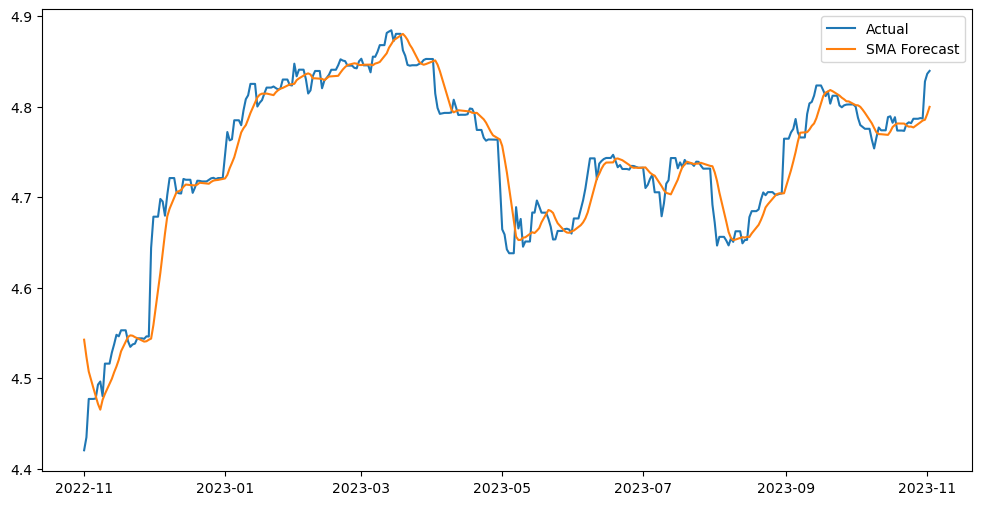

In [99]:
#Plotting the test results 
plt.figure(figsize=(12, 6))
plt.plot(y_test_front, label='Actual')  # Actual test set values
plt.plot(forecast_sma, label='SMA Forecast')  # SMA forecasted values
plt.legend()
plt.show()

In [100]:
#Forecasting using SMA

y_train_second.index = pd.to_datetime(y_train_second.index)
y_test_second.index = pd.to_datetime(y_test_second.index)

y_train_second = y_train_second.asfreq('D')
y_test_second = y_test_second.asfreq('D')

y_train_second_series = y_train_second['CLOSE_y']
y_test_second_series = y_test_second['CLOSE_y']

window = 7  #Weekly window
forecast_sma_second = sma_forecast(y_train_second_series, y_test_second_series, window)

#Test evaluation
mae_sma_second = mean_absolute_error(y_test_second_series, forecast_sma_second)
rmse_sma_second = np.sqrt(mean_squared_error(y_test_second_series, forecast_sma_second))
mape_sma_second = custom_mape(y_test_second_series, forecast_sma_second)
r2_sma_second = r2_score(y_test_second_series, forecast_sma_second)

print(f'Simple Moving Average Model - MAE: {mae_sma_second}, RMSE: {rmse_sma_second}, MAPE: {mape_sma_second}%, R-squared: {r2_sma_second}')

# Forecast on the training set using the same SMA model
train_forecast_sma_second = y_train_second_series.rolling(window=window).mean()

#Training evaluation
train_mae_sma_second = mean_absolute_error(y_train_second_series[window-1:], train_forecast_sma_second[window-1:])
train_rmse_sma_second = np.sqrt(mean_squared_error(y_train_second_series[window-1:], train_forecast_sma_second[window-1:]))
train_mape_sma_second = custom_mape(y_train_second_series[window-1:], train_forecast_sma_second[window-1:])
train_r2_sma_second = r2_score(y_train_second_series[window-1:], train_forecast_sma_second[window-1:])

print(f'Training Simple Moving Average Model - MAE: {train_mae_sma_second}, RMSE: {train_rmse_sma_second}, MAPE: {train_mape_sma_second}%, R-squared: {train_r2_sma_second}')

Simple Moving Average Model - MAE: 0.023412435119093546, RMSE: 0.029264586778428484, MAPE: 0.4969466027215213%, R-squared: 0.89684079321873
Training Simple Moving Average Model - MAE: 0.021205289178097865, RMSE: 0.0293459440708292, MAPE: 0.47974315245492805%, R-squared: 0.9943162709236479


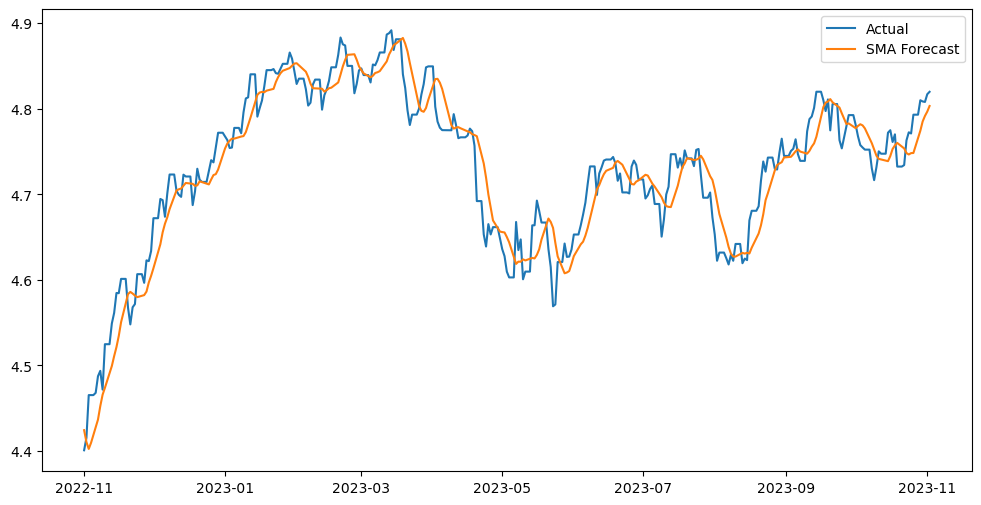

In [101]:
#Plotting test result

plt.figure(figsize=(12, 6))
plt.plot(y_test_second, label='Actual')  # Actual test set values
plt.plot(forecast_sma_second, label='SMA Forecast')  # SMA forecasted values
plt.legend()
plt.show()

## SARIMA <a class="anchor" id="SARIMA"></a>

A SARIMA model has been fit below with parameters initalised according to the ACF and PACF observations

                                      SARIMAX Results                                       
Dep. Variable:                              CLOSE_x   No. Observations:                 2859
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 30)   Log Likelihood                7438.453
Date:                              Thu, 01 Aug 2024   AIC                         -14866.906
Time:                                      21:36:23   BIC                         -14837.170
Sample:                                  01-02-2015   HQIC                        -14856.178
                                       - 10-30-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.014      1.277      0.202      -0.009       0.044
ar.S.L30      -0.01

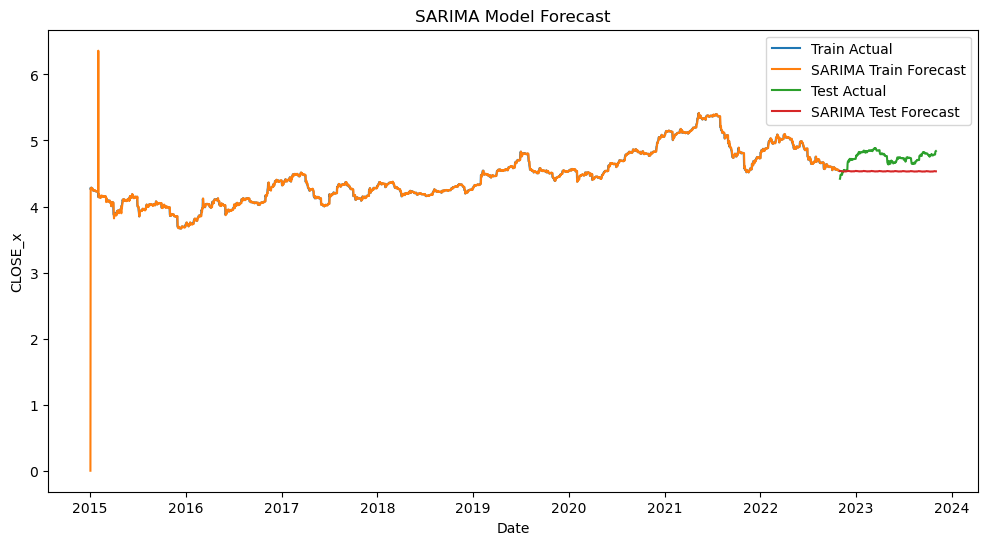

In [102]:
#Initialising parameters and fitting model
seasonal_order = (2, 1, 1, 30)  # Seasonal parameters (P, D, Q, s)
order = (1, 1, 0)  # Non-seasonal parameters (p, d, q)
model = SARIMAX(y_train_front, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)
print(model_fit.summary())

#Test forecast
forecast_steps = len(y_test_front)
forecast_sarima = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast_sarima.conf_int()

forecast_sarima_mean = forecast_sarima.predicted_mean

forecast_sarima_mean = pd.Series(forecast_sarima_mean, index=y_test_front.index)

#Filling NaN generated during forecasting
forecast_sarima_mean_cleaned = forecast_sarima_mean.ffill()

#Test eval
mae_sarima_front = mean_absolute_error(y_test_front, forecast_sarima_mean_cleaned)
rmse_sarima_front = np.sqrt(mean_squared_error(y_test_front, forecast_sarima_mean_cleaned))
mape_sarima_front = custom_mape(y_test_front, forecast_sarima_mean_cleaned)
r2_sarima_front = r2_score(y_test_front, forecast_sarima_mean_cleaned)

print(f'Mean Absolute Error (MAE): {mae_sarima_front}')
print(f'Root Mean Squared Error (RMSE): {rmse_sarima_front}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_sarima_front}%')
print(f'R-squared: {r2_sarima_front}')

#Forecast on fitted data
train_forecast_sarima = model_fit.fittedvalues

#Train eval
train_mae_sarima_front = mean_absolute_error(y_train_front, train_forecast_sarima)
train_rmse_sarima_front = np.sqrt(mean_squared_error(y_train_front, train_forecast_sarima))
train_mape_sarima_front = custom_mape(y_train_front, train_forecast_sarima)
train_r2_sarima_front = r2_score(y_train_front, train_forecast_sarima)

print(f'Training Mean Absolute Error (MAE): {train_mae_sarima_front}')
print(f'Training Root Mean Squared Error (RMSE): {train_rmse_sarima_front}')
print(f'Training Mean Absolute Percentage Error (MAPE): {train_mape_sarima_front}%')
print(f'Training R-squared: {train_r2_sarima_front}')

#Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_front.index, y_train_front, label='Train Actual')
plt.plot(y_train_front.index, train_forecast_sarima, label='SARIMA Train Forecast')
plt.plot(y_test_front.index, y_test_front, label='Test Actual')
plt.plot(y_test_front.index, forecast_sarima_mean_cleaned, label='SARIMA Test Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('CLOSE_x')
plt.title('SARIMA Model Forecast')
plt.show()

### Second-month 

                                      SARIMAX Results                                       
Dep. Variable:                              CLOSE_x   No. Observations:                 2859
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 30)   Log Likelihood                7438.453
Date:                              Thu, 01 Aug 2024   AIC                         -14866.906
Time:                                      21:40:02   BIC                         -14837.170
Sample:                                  01-02-2015   HQIC                        -14856.178
                                       - 10-30-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.014      1.277      0.202      -0.009       0.044
ar.S.L30      -0.01

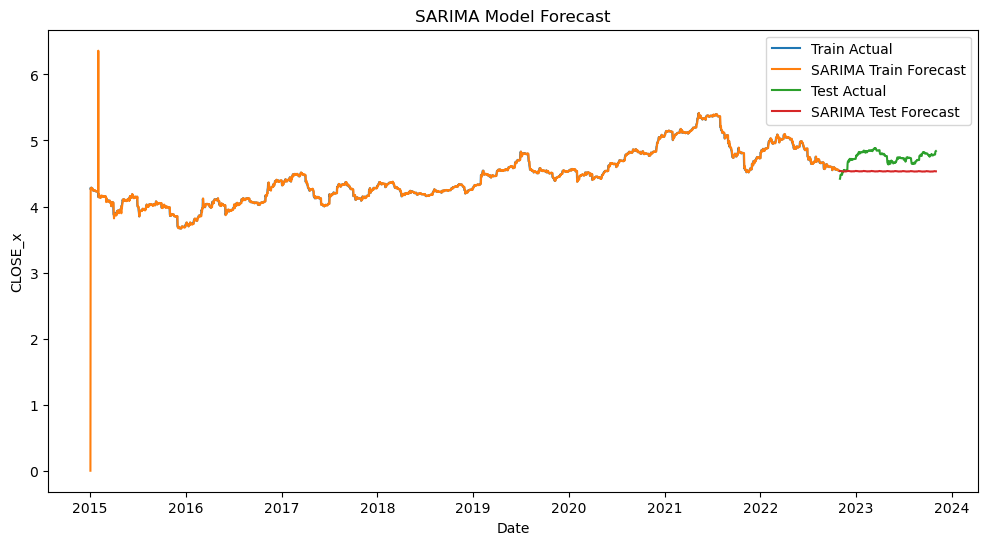

In [104]:
#Repeating SARIMA training and eval for second-month 

seasonal_order = (2, 1, 1, 30)  # Seasonal parameters (P, D, Q, s)
order = (1, 1, 0)  # Non-seasonal parameters (p, d, q)
model = SARIMAX(y_train_front, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)
print(model_fit.summary())

forecast_steps = len(y_test_front)
forecast_sarima = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast_sarima.conf_int()

forecast_sarima_mean = forecast_sarima.predicted_mean

forecast_sarima_mean = pd.Series(forecast_sarima_mean, index=y_test_front.index)

forecast_sarima_mean_cleaned = forecast_sarima_mean.ffill()

#Test eval
mae_sarima_second = mean_absolute_error(y_test_front[:-1], forecast_sarima_mean_cleaned[:-1])
rmse_sarima_second = np.sqrt(mean_squared_error(y_test_front[:-1], forecast_sarima_mean_cleaned[:-1]))
mape_sarima_second = np.mean(np.abs((y_test_front[:-1] - forecast_sarima_mean_cleaned[:-1]) / y_test_front[:-1])) * 100
r2_sarima_second = r2_score(y_test_front[:-1], forecast_sarima_mean_cleaned[:-1])

print(f'Mean Absolute Error (MAE): {mae_sarima_second}')
print(f'Root Mean Squared Error (RMSE): {rmse_sarima_second}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_sarima_second}%')
print(f'R-squared: {r2_sarima_second}')

train_forecast_sarima = model_fit.fittedvalues

#Train eval
train_mae_sarima_second = mean_absolute_error(y_train_front, train_forecast_sarima)
train_rmse_sarima_second = np.sqrt(mean_squared_error(y_train_front, train_forecast_sarima))
train_mape_sarima_second = np.mean(np.abs((y_train_front - train_forecast_sarima) / y_train_front)) * 100
train_r2_sarima_second = r2_score(y_train_front, train_forecast_sarima)

print(f'Training Mean Absolute Error (MAE): {train_mae_sarima_second}')
print(f'Training Root Mean Squared Error (RMSE): {train_rmse_sarima_second}')
print(f'Training Mean Absolute Percentage Error (MAPE): {train_mape_sarima_second}%')
print(f'Training R-squared: {train_r2_sarima_second}')

#Plotting results
plt.figure(figsize=(12, 6))
plt.plot(y_train_front.index, y_train_front, label='Train Actual')
plt.plot(y_train_front.index, train_forecast_sarima, label='SARIMA Train Forecast')
plt.plot(y_test_front.index, y_test_front, label='Test Actual')
plt.plot(y_test_front.index, forecast_sarima_mean_cleaned, label='SARIMA Test Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('CLOSE_x')
plt.title('SARIMA Model Forecast')
plt.show()

## Holt-Winters Seasonal Model (Triple Exponential Smoothing) <a class="anchor" id="Holt-Winters"></a>

A Holt-Winters model has been trained and evaluated as the final baseline model tested

In [105]:
y_train_front.index = pd.to_datetime(y_train_front.index)
y_test_front.index = pd.to_datetime(y_test_front.index)

y_train_front = y_train_front.asfreq('D')
y_test_front = y_test_front.asfreq('D')

#Fitting the ETS model on the training data
ets_model = ExponentialSmoothing(y_train_front, seasonal_periods=30, trend='add', seasonal='add').fit()
print(ets_model.summary()) #checking results

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  CLOSE_x   No. Observations:                 2859
Model:             ExponentialSmoothing   SSE                              0.819
Optimized:                         True   AIC                         -23255.665
Trend:                         Additive   BIC                         -23053.086
Seasonal:                      Additive   AICC                        -23254.721
Seasonal Periods:                    30   Date:                 Thu, 01 Aug 2024
Box-Cox:                          False   Time:                         21:40:02
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

Mean Absolute Error (MAE): 0.19326919236037277
Root Mean Squared Error (RMSE): 0.20940034178609532
Mean Absolute Percentage Error (MAPE): 4.08674819518682%
R-squared: -4.359253109144943
Training Mean Absolute Error (MAE): 0.008160382507164141
Training Root Mean Squared Error (RMSE): 0.016924549523408258
Training Mean Absolute Percentage Error (MAPE): 9.823016160439499%
Training R-squared: 0.9980866250631214


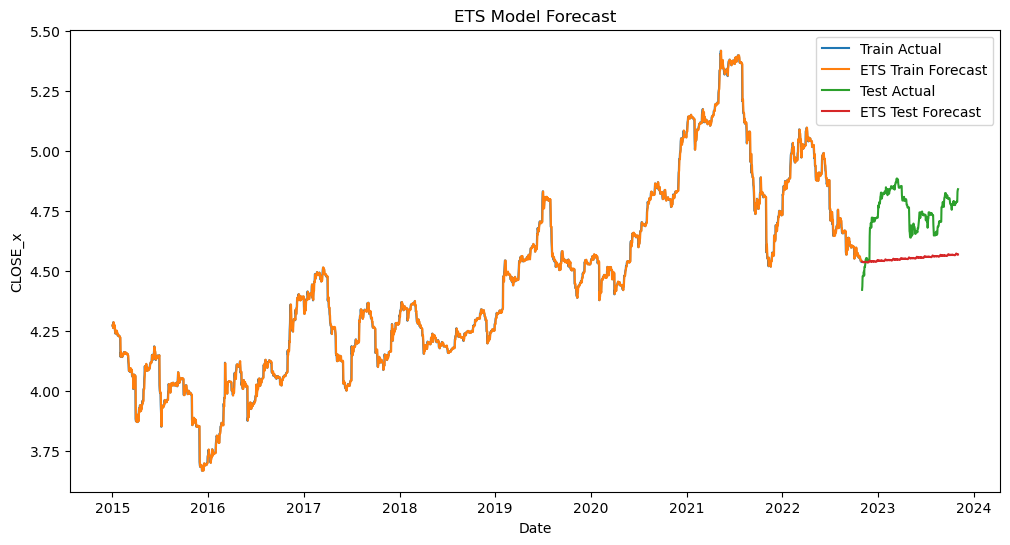

In [106]:
#Test forecast
forecast_steps = len(y_test_front)
forecast_ets = ets_model.forecast(steps=forecast_steps)

forecast_ets = pd.Series(forecast_ets, index=y_test_front.index)

#Filling NaN generated during forecasting
forecast_ets_cleaned = forecast_ets.ffill()

#Test eval
mae_ets_front = mean_absolute_error(y_test_front, forecast_ets_cleaned)
rmse_ets_front = np.sqrt(mean_squared_error(y_test_front, forecast_ets_cleaned))
mape_ets_front = custom_mape(y_test_front, forecast_ets_cleaned)
r2_ets_front = r2_score(y_test_front, forecast_ets_cleaned)

print(f'Mean Absolute Error (MAE): {mae_ets_front}')
print(f'Root Mean Squared Error (RMSE): {rmse_ets_front}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_ets_front}%')
print(f'R-squared: {r2_ets_front}')

#Forecast on fitted values
train_forecast_ets = ets_model.fittedvalues

#Train eval
mae_train_ets_front = mean_absolute_error(y_train_front, train_forecast_ets)
rmse_train_ets_front = np.sqrt(mean_squared_error(y_train_front, train_forecast_ets))
mape_train_ets_front = custom_mape(y_train_front, train_forecast_ets)
r2_train_ets_front = r2_score(y_train_front, train_forecast_ets)

print(f'Training Mean Absolute Error (MAE): {mae_train_ets_front}')
print(f'Training Root Mean Squared Error (RMSE): {rmse_train_ets_front}')
print(f'Training Mean Absolute Percentage Error (MAPE): {mape_train_ets_front}%')
print(f'Training R-squared: {r2_train_ets_front}')

#Plotting results
plt.figure(figsize=(12, 6))
plt.plot(y_train_front.index, y_train_front, label='Train Actual')  # Actual training set values
plt.plot(y_train_front.index, train_forecast_ets, label='ETS Train Forecast')  # ETS training set forecast
plt.plot(y_test_front.index, y_test_front, label='Test Actual')  # Actual test set values
plt.plot(y_test_front.index, forecast_ets_cleaned, label='ETS Test Forecast')  # ETS forecasted values
plt.legend()
plt.xlabel('Date')
plt.ylabel('CLOSE_x')
plt.title('ETS Model Forecast')
plt.show()

In [107]:
#Repeating ETS training and eval for second-month contracts

y_train_second.index = pd.to_datetime(y_train_second.index)
y_test_second.index = pd.to_datetime(y_test_second.index)

y_train_second = y_train_second.asfreq('D')
y_test_second = y_test_second.asfreq('D')

ets_model_second = ExponentialSmoothing(y_train_second, seasonal_periods=30, trend='add', seasonal='add').fit()
print(ets_model_second.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  CLOSE_y   No. Observations:                 2859
Model:             ExponentialSmoothing   SSE                              1.298
Optimized:                         True   AIC                         -21939.826
Trend:                         Additive   BIC                         -21737.246
Seasonal:                      Additive   AICC                        -21938.882
Seasonal Periods:                    30   Date:                 Thu, 01 Aug 2024
Box-Cox:                          False   Time:                         21:40:03
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

Mean Absolute Error (MAE): 0.3515666479005406
Root Mean Squared Error (RMSE): 0.363103580741056
Mean Absolute Percentage Error (MAPE): 7.396070976477444%
R-squared: -14.881234743128573
Training Mean Absolute Error (MAE): 0.013316982375322962
Training Root Mean Squared Error (RMSE): 0.02130384254921744
Training Mean Absolute Percentage Error (MAPE): 9.944576082820472%
Training R-squared: 0.9969993939003535


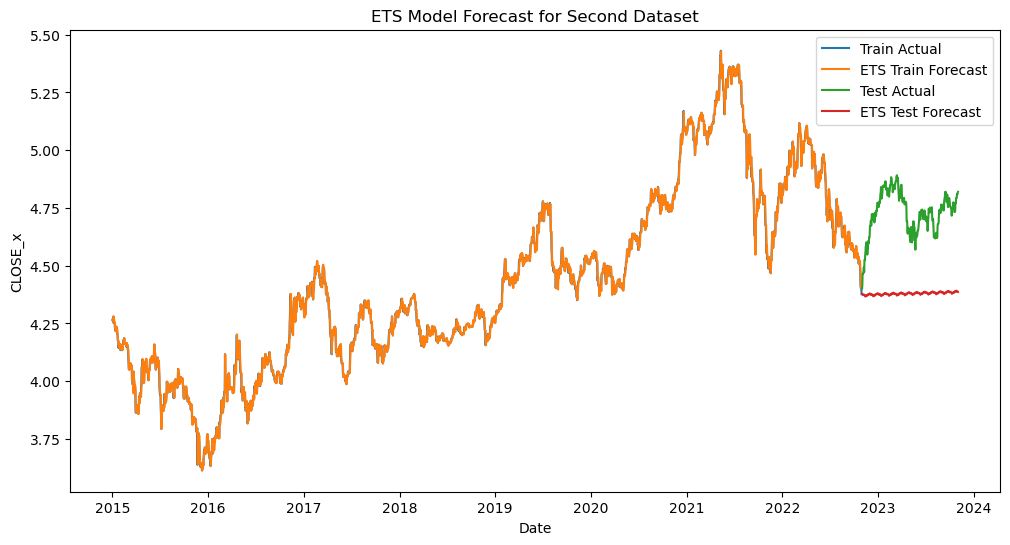

In [108]:
#Test forecast
forecast_steps_second = len(y_test_second)
forecast_ets_second = ets_model_second.forecast(steps=forecast_steps_second)

forecast_ets_second = pd.Series(forecast_ets_second, index=y_test_second.index)

#Filling NaN generated during forecasting
forecast_ets_second_cleaned = forecast_ets_second.ffill()

#Test evaluation
mae_ets_second = mean_absolute_error(y_test_second, forecast_ets_second_cleaned)
rmse_ets_second = np.sqrt(mean_squared_error(y_test_second, forecast_ets_second_cleaned))
mape_ets_second = custom_mape(y_test_second, forecast_ets_second_cleaned)
r2_ets_second = r2_score(y_test_second, forecast_ets_second_cleaned)

print(f'Mean Absolute Error (MAE): {mae_ets_second}')
print(f'Root Mean Squared Error (RMSE): {rmse_ets_second}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_ets_second}%')
print(f'R-squared: {r2_ets_second}')

#Forecast on fitted values
train_forecast_ets_second = ets_model_second.fittedvalues

#Training evaluation
mae_train_ets_second = mean_absolute_error(y_train_second, train_forecast_ets_second)
rmse_train_ets_second = np.sqrt(mean_squared_error(y_train_second, train_forecast_ets_second))
mape_train_ets_second = custom_mape(y_train_second, train_forecast_ets_second)
r2_train_ets_second = r2_score(y_train_second, train_forecast_ets_second)

print(f'Training Mean Absolute Error (MAE): {mae_train_ets_second}')
print(f'Training Root Mean Squared Error (RMSE): {rmse_train_ets_second}')
print(f'Training Mean Absolute Percentage Error (MAPE): {mape_train_ets_second}%')
print(f'Training R-squared: {r2_train_ets_second}')

#Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_second.index, y_train_second, label='Train Actual')  # Actual training set values
plt.plot(y_train_second.index, train_forecast_ets_second, label='ETS Train Forecast')  # ETS training set forecast
plt.plot(y_test_second.index, y_test_second, label='Test Actual')  # Actual test set values
plt.plot(y_test_second.index, forecast_ets_second_cleaned, label='ETS Test Forecast')  # ETS forecasted values
plt.legend()
plt.xlabel('Date')
plt.ylabel('CLOSE_x')
plt.title('ETS Model Forecast for Second Dataset')
plt.show()

### Training Results 

In [112]:
#Converting metrics to original scale 
train_mae_sma_front = np.exp(train_mae_sma_front) - 1 
train_mae_sarima_front = np.exp(train_mae_sarima_front) - 1 
train_mae_ets_front = np.exp(mae_train_ets_front) - 1 


train_rmse_sma_front = np.exp(train_rmse_sma_front) - 1
train_rmse_sarima_front = np.exp(train_rmse_sarima_front) - 1 
train_rmse_ets_front = np.exp(rmse_train_ets_front) - 1 

model_names = ['SMA', 'SARIMA', 'Holt-Winters']
train_mae_front_list = [train_mae_sma_front, train_mae_sarima_front, train_mae_ets_front]  
train_rmse_front_list = [train_rmse_sma_front, train_rmse_sarima_front, train_rmse_ets_front]  
train_mape_front_list = [train_mape_sma_front, train_mape_sarima_front, mape_train_ets_front] 
train_r2_front_list = [train_r2_sma_front, train_r2_sarima_front, r2_train_ets_front]  

#Storing train results for front-month
train_results_dict_front = {
    'Model': model_names,
    'MAE': train_mae_front_list,
    'RMSE': train_rmse_front_list,
    'MAPE': train_mape_front_list,
    'R-squared': train_r2_front_list
}


baseline_models_train_results_front = pd.DataFrame(train_results_dict_front)

In [113]:
#Converting metrics to original scale 
train_mae_sma_second = np.exp(train_mae_sma_second) - 1 
train_mae_sarima_second = np.exp(train_mae_sarima_second) - 1 
train_mae_ets_second = np.exp(mae_train_ets_second) - 1 


train_rmse_sma_second = np.exp(train_rmse_sma_second) - 1
train_rmse_sarima_second = np.exp(train_rmse_sarima_second) - 1 
train_rmse_ets_second = np.exp(rmse_train_ets_second) - 1 

model_names = ['SMA', 'SARIMA', 'Holt-Winters']
train_mae_second_list = [train_mae_sma_second, train_mae_sarima_second, train_mae_ets_second]  
train_rmse_second_list = [train_rmse_sma_second, train_rmse_sarima_second, train_rmse_ets_second]  
train_mape_second_list = [train_mape_sma_second, train_mape_sarima_second, mape_train_ets_second] 
train_r2_second_list = [train_r2_sma_second, train_r2_sarima_second, r2_train_ets_second]  

#Storing train results for second-month
train_results_dict_second = {
    'Model': model_names,
    'MAE': train_mae_second_list,
    'RMSE': train_rmse_second_list,
    'MAPE': train_mape_second_list,
    'R-squared': train_r2_second_list
}


baseline_models_train_results_second = pd.DataFrame(train_results_dict_second)

### Test Results 

In [115]:
#Converting metrics to original scale 
mae_sma_front = np.exp(mae_sma_front) - 1 
mae_sarima_front = np.exp(mae_sarima_front) - 1 
mae_ets_front = np.exp(mae_ets_front) - 1 


rmse_sma_front = np.exp(rmse_sma_front) - 1
rmse_sarima_front = np.exp(rmse_sarima_front) - 1 
rmse_ets_front = np.exp(rmse_ets_front) - 1 

model_names = ['SMA', 'SARIMA', 'Holt-Winters']
mae_front_list = [mae_sma_front, mae_sarima_front, mae_ets_front]  
rmse_front_list = [rmse_sma_front, rmse_sarima_front, rmse_ets_front]  
mape_front_list = [mape_sma_front, mape_sarima_front, mape_ets_front] 
r2_front_list = [r2_sma_front, r2_sarima_front, r2_ets_front]  

#Storing test results for front-month
results_dict_front = {
    'Model': model_names,
    'MAE': mae_front_list,
    'RMSE': rmse_front_list,
    'MAPE': mape_front_list,
    'R-squared': r2_front_list
}


baseline_models_results_front = pd.DataFrame(results_dict_front)

In [116]:
#Converting metrics to original scale 
mae_sma_second = np.exp(mae_sma_second) - 1 
mae_sarima_second = np.exp(mae_sarima_second) - 1 
mae_ets_second = np.exp(mae_ets_second) - 1 

rmse_sma_second = np.exp(rmse_sma_second) - 1
rmse_sarima_second = np.exp(rmse_sarima_second) - 1 
rmse_ets_second = np.exp(rmse_ets_second) - 1 


model_names = ['SMA', 'SARIMA', 'Holt-Winters']
mae_second_list = [mae_sma_second, mae_sarima_second, mae_ets_second]  
rmse_second_list = [rmse_sma_second, rmse_sarima_second, rmse_ets_second]  
mape_second_list = [mape_sma_second, mape_sarima_second, mape_ets_second] 
r2_second_list = [r2_sma_front, r2_sarima_front, r2_ets_second]  


#Storing test results for second-month
results_dict_second = {
    'Model': model_names,
    'MAE': mae_second_list,
    'RMSE': rmse_second_list,
    'MAPE': mape_second_list,
    'R-squared': r2_second_list
}

baseline_models_results_second = pd.DataFrame(results_dict_second)

In [ ]:
#Saving the baseline results dfs 

#Train results
baseline_models_train_results_front.to_csv('baseline_models_train_results_front.csv', index=False)
baseline_models_train_results_second.to_csv('baseline_models_train_results_second.csv', index=False)

#Test results
baseline_models_results_front.to_csv('baseline_models_results_front.csv', index=False)
baseline_models_results_second.to_csv('baseline_models_results_second.csv', index=False)